# Oxygen Distribution in Tissue: Finite Difference Solution

This notebook presents a numerical solution of a time-dependent reaction–diffusion equation describing oxygen transport in biological tissue. The governing partial differential equation (PDE) is discretised using finite difference (FD) approximations and solved numerically to analyse the temporal evolution of oxygen concentration.

## Mathematical Model

The oxygen concentration \(O(x,t)\) in tissue is modelled by the following reaction–diffusion equation:

$$
\frac{\partial O}{\partial t}
=
D \nabla^2 O
-
\mu O
+
S
$$

where:
- D is the oxygen diffusion coefficient,
- mu is the oxygen consumption rate,
- S represents an external oxygen supply.

## Finite Difference Approximations

The time derivative is approximated using a forward difference:

$$
\frac{\partial O}{\partial t}
\approx
\frac{O_i^{n+1} - O_i^n}{\Delta t}
$$

The second spatial derivative is approximated using a central difference:

$$
\nabla^2 O
\approx
\frac{O_{i-1}^n - 2O_i^n + O_{i+1}^n}{\Delta x^2}
$$

## Discrete Update Equation

Substituting the finite difference approximations into the governing equation yields the following explicit update scheme:

$$
O_i^{n+1}
=
O_i^n
+
\Delta t
\left[
D \frac{O_{i-1}^n - 2O_i^n + O_{i+1}^n}{\Delta x^2}
-
\mu O_i^n
+
S
\right]
$$

This corresponds to an explicit finite difference scheme using forward Euler discretisation in time and central differences in space.

## Model Parameters

The parameters used in the simulation are chosen within the ranges provided in the task description and represent typical physiological values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
D = 0.05        # diffusion coefficient (cm^2/day)
mu = 0.005      # consumption rate (1/day)
S = 5.0         # external supply (mg/(cm^3·day))


## Spatial Domain and Grid

The spatial domain is defined on the interval [0, L] and discretised into equally spaced grid points.


In [2]:
# Spatial grid
L = 1.0               # domain length (cm)
Nx = 50               # number of spatial points
dx = L / (Nx - 1)
x = np.linspace(0, L, Nx)

# Time grid
T = 1.0               # final time (days)
dt = 0.0005           # time step (days)
Nt = int(T / dt)


## Initial and Boundary Conditions

A uniform initial oxygen concentration is assumed throughout the tissue.

A Dirichlet boundary condition is applied at the left boundary to represent oxygen supply from blood vessels. A no-flux (Neumann) boundary condition is applied at the right boundary.


In [3]:
# Initial condition
O = np.ones(Nx) * 1.0

# Boundary condition value (Dirichlet)
O_left = 1.0


## Time Integration

The finite difference update equation is applied iteratively in time. Boundary conditions are enforced at each time step.


In [4]:
# Store solution for plotting
O_history = [O.copy()]

for n in range(Nt):
    O_new = O.copy()
    
    # Interior points
    for i in range(1, Nx - 1):
        O_new[i] = (
            O[i]
            + dt * (
                D * (O[i-1] - 2*O[i] + O[i+1]) / dx**2
                - mu * O[i]
                + S
            )
        )
    
    # Boundary conditions
    O_new[0] = O_left                   # Dirichlet
    O_new[-1] = O_new[-2]               # Neumann (no flux)
    
    O = O_new
    O_history.append(O.copy())


## Visualisation of Results

The oxygen concentration is plotted at different time points to illustrate its temporal evolution.


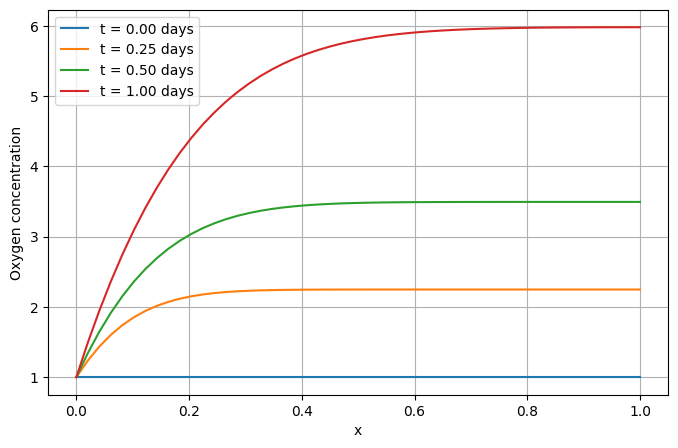

In [5]:
plt.figure(figsize=(8,5))
for idx in [0, int(Nt/4), int(Nt/2), Nt]:
    plt.plot(x, O_history[idx], label=f"t = {idx*dt:.2f} days")

plt.xlabel("x")
plt.ylabel("Oxygen concentration")
plt.legend()
plt.grid()
plt.show()


## Interpretation of Results

The results illustrate the temporal evolution of the oxygen concentration within the tissue. At the initial time \(t = 0\), the oxygen concentration is uniform throughout the domain. As time progresses, oxygen diffuses into the tissue from the boundary, leading to an increase in concentration across the spatial domain. The concentration rises more rapidly near the boundary where oxygen is supplied, while diffusion gradually transports oxygen deeper into the tissue. 

Over time, the profiles become smoother and approach a steady-state shape, indicating a balance between diffusion, cellular consumption, and external oxygen supply. This behaviour is characteristic of reaction–diffusion systems and demonstrates how diffusion counteracts consumption to establish a stable oxygen distribution.



# Stability Analysis

The numerical solution is obtained using an explicit finite difference scheme. Such schemes are conditionally stable, meaning that the choice of the time step \(\Delta t\) relative to the spatial grid size \(\Delta x\) is crucial for stability.

For diffusion-dominated problems, the forward Euler scheme combined with central spatial differences is stable only if the time step satisfies a certain restriction.

## Stability Condition

For the one-dimensional diffusion equation, the stability condition for the explicit finite difference scheme is given by

$$
\Delta t \le \frac{\Delta x^2}{2D}.
$$

In the presence of a linear reaction term, this condition remains a sufficient criterion for stability. In the following, this condition is investigated experimentally by comparing stable and unstable choices of the time step.



In [6]:
# Stability limit for explicit diffusion scheme
dt_stable = dx**2 / (2 * D)
dt_stable


0.004164931278633902

## Experimental Investigation of Stability

To investigate stability experimentally, the numerical solution is computed using two different time step sizes:
- one satisfying the stability condition,
- one exceeding the stability limit.

The resulting solutions are compared to illustrate stable and unstable behaviour.


In [8]:
def run_simulation(dt_test, Nt_test):
    O = np.ones(Nx)
    history = []
    
    for n in range(Nt_test):
        O_new = O.copy()
        for i in range(1, Nx - 1):
            O_new[i] = (
                O[i]
                + dt_test * (
                    D * (O[i-1] - 2*O[i] + O[i+1]) / dx**2
                    - mu * O[i]
                    + S
                )
            )
        O_new[0] = O_left
        O_new[-1] = O_new[-2]
        O = O_new
        history.append(O.copy())
        
    return np.array(history)

# Stable and unstable time steps
dt_good = 0.5 * dt_stable
dt_bad = 2.0 * dt_stable

Nt_test = 200

stable_sol = run_simulation(dt_good, Nt_test)
unstable_sol = run_simulation(dt_bad, Nt_test)


## Comparison of Stable and Unstable Solutions

The spatial oxygen concentration at the final time step is plotted for both simulations.


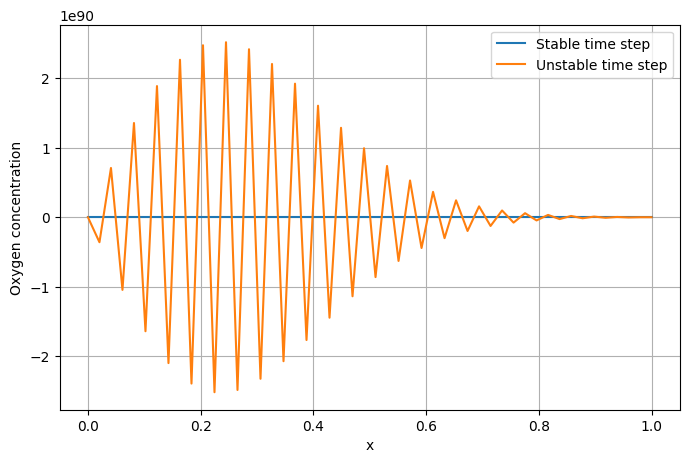

In [9]:
plt.figure(figsize=(8,5))
plt.plot(x, stable_sol[-1], label="Stable time step")
plt.plot(x, unstable_sol[-1], label="Unstable time step")
plt.xlabel("x")
plt.ylabel("Oxygen concentration")
plt.legend()
plt.grid()
plt.show()


## Interpretation of Stability Results

The comparison demonstrates the conditional stability of the explicit finite difference scheme. When the time step satisfies the stability condition, the numerical solution remains smooth and bounded. In contrast, choosing a time step larger than the stability limit leads to numerical instability, characterised by strong oscillations and unphysically large values. This behaviour confirms that the explicit scheme is unstable for excessively large time steps and highlights the importance of satisfying the stability criterion.
